# Machine Learning Models

This notebook contains the implementation and evaluation of various machine learning models for match prediction using the engineered features.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

## Load the Training and Test Sets

In [11]:
# Load the training and test sets from the Features folder
X_train = pd.read_csv('Features/TrainingSet/features.csv')
y_train = pd.read_csv('Features/TrainingSet/matches_engineered.csv')['FTR']
X_train_weather = pd.read_csv('Features/TrainingSet/features_weather.csv')
y_train_weather = pd.read_csv('Features/TrainingSet/matches_engineered_weather.csv')['FTR']
X_val = pd.read_csv('Features/ValidationSet/features.csv')
y_val = pd.read_csv('Features/ValidationSet/matches_engineered.csv')['FTR']
X_val_weather = pd.read_csv('Features/ValidationSet/features_weather.csv')
y_val_weather = pd.read_csv('Features/ValidationSet/matches_engineered_weather.csv')['FTR']
X_test = pd.read_csv('Features/TestSet/features.csv')
y_test = pd.read_csv('Features/TestSet/matches_engineered.csv')['FTR']
X_test_weather = pd.read_csv('Features/TestSet/features_weather.csv')
y_test_weather = pd.read_csv('Features/TestSet/matches_engineered_weather.csv')['FTR']

# Convert target variables to numpy arrays if they're dataframes
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.values.ravel()
if isinstance(y_val, pd.DataFrame):
    y_val = y_val.values.ravel()
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.values.ravel()

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target distribution in training set:\n{pd.Series(y_train).value_counts(normalize=True)}")

Training set shape: (1520, 15)
Validation set shape: (380, 15)
Test set shape: (380, 15)
Target distribution in training set:
FTR
H    0.457237
A    0.280921
D    0.261842
Name: proportion, dtype: float64


## Helper Functions for Model Evaluation

In [12]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    """Evaluate a model on training and validation sets, optionally on test set."""
    # Training set performance
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    
    # Validation set performance
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Create results dictionary
    results = {
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    }
    
    # Test set performance (if provided)
    if X_test is not None and y_test is not None:
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='weighted')
        test_recall = recall_score(y_test, y_test_pred, average='weighted')
        test_f1 = f1_score(y_test, y_test_pred, average='weighted')
        
        results.update({
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1
        })
    
    return results

def plot_confusion_matrix(model, X, y, title='Confusion Matrix'):
    """Plot confusion matrix for a model's predictions."""
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(classification_report(y, y_pred))

def plot_feature_importance(model, feature_names, top_n=20, title='Feature Importance'):
    """Plot feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        
        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot top N features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
        plt.title(title)
        plt.tight_layout()
        plt.show()
        
        return feature_importance_df
    else:
        print("This model doesn't have feature_importances_ attribute.")
        return None

## Random Forest Classifier

Random Forest Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4316
val_precision: 0.4008
val_recall: 0.4316
val_f1: 0.4019


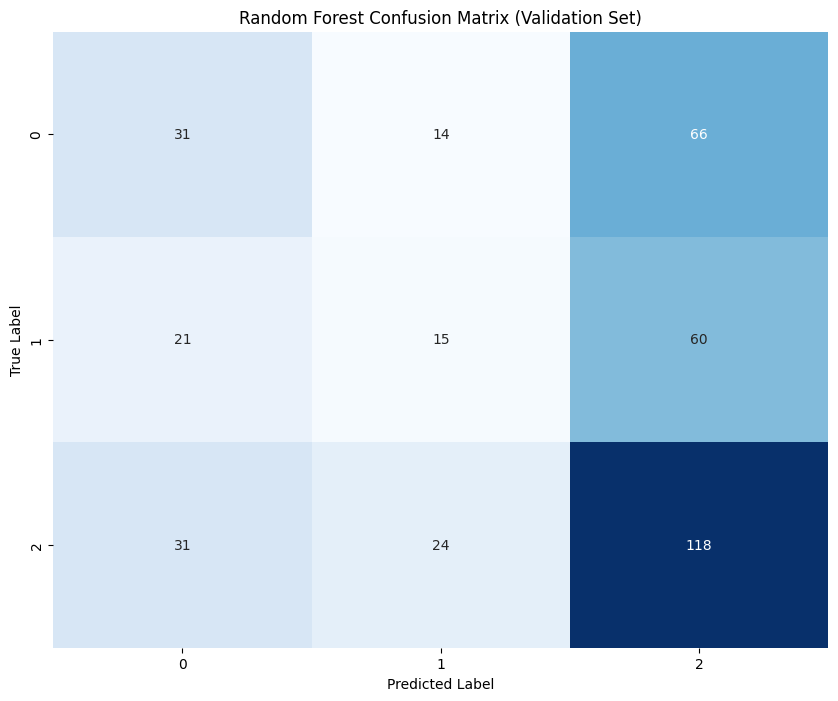

              precision    recall  f1-score   support

           A       0.37      0.28      0.32       111
           D       0.28      0.16      0.20        96
           H       0.48      0.68      0.57       173

    accuracy                           0.43       380
   macro avg       0.38      0.37      0.36       380
weighted avg       0.40      0.43      0.40       380



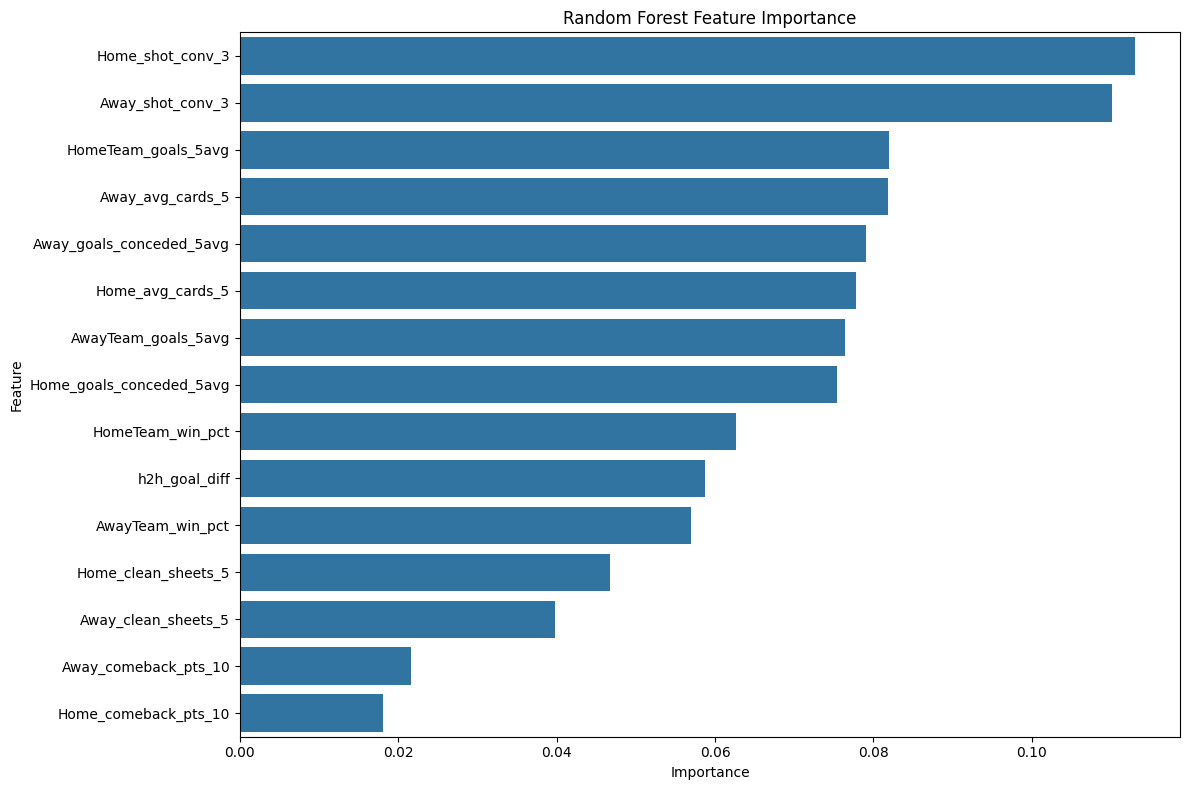

Random Forest Results With Weather:
train_accuracy: 1.0000
train_precision: 1.0000
train_recall: 1.0000
train_f1: 1.0000
val_accuracy: 0.4342
val_precision: 0.4022
val_recall: 0.4342
val_f1: 0.4019


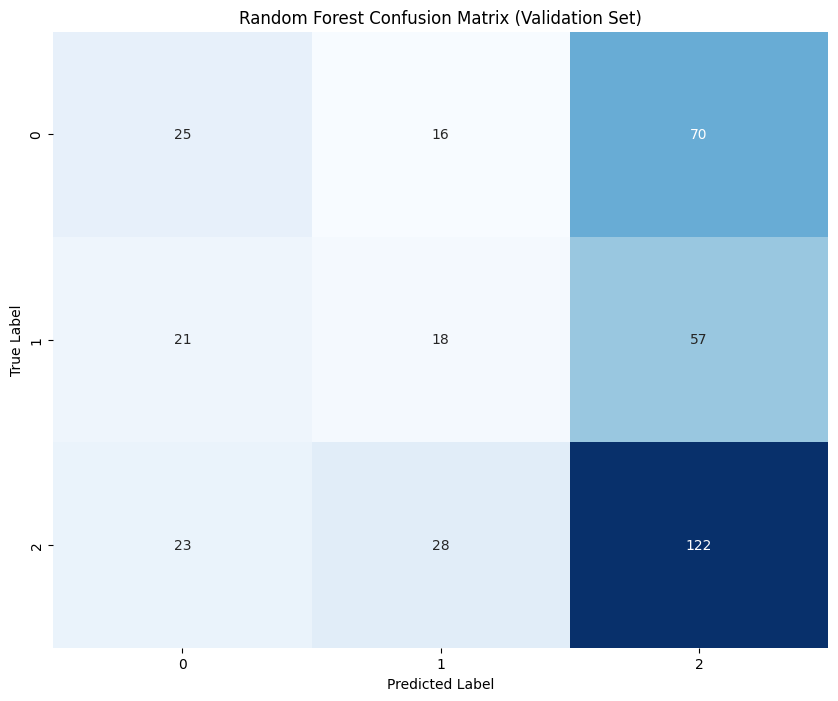

              precision    recall  f1-score   support

           A       0.36      0.23      0.28       111
           D       0.29      0.19      0.23        96
           H       0.49      0.71      0.58       173

    accuracy                           0.43       380
   macro avg       0.38      0.37      0.36       380
weighted avg       0.40      0.43      0.40       380



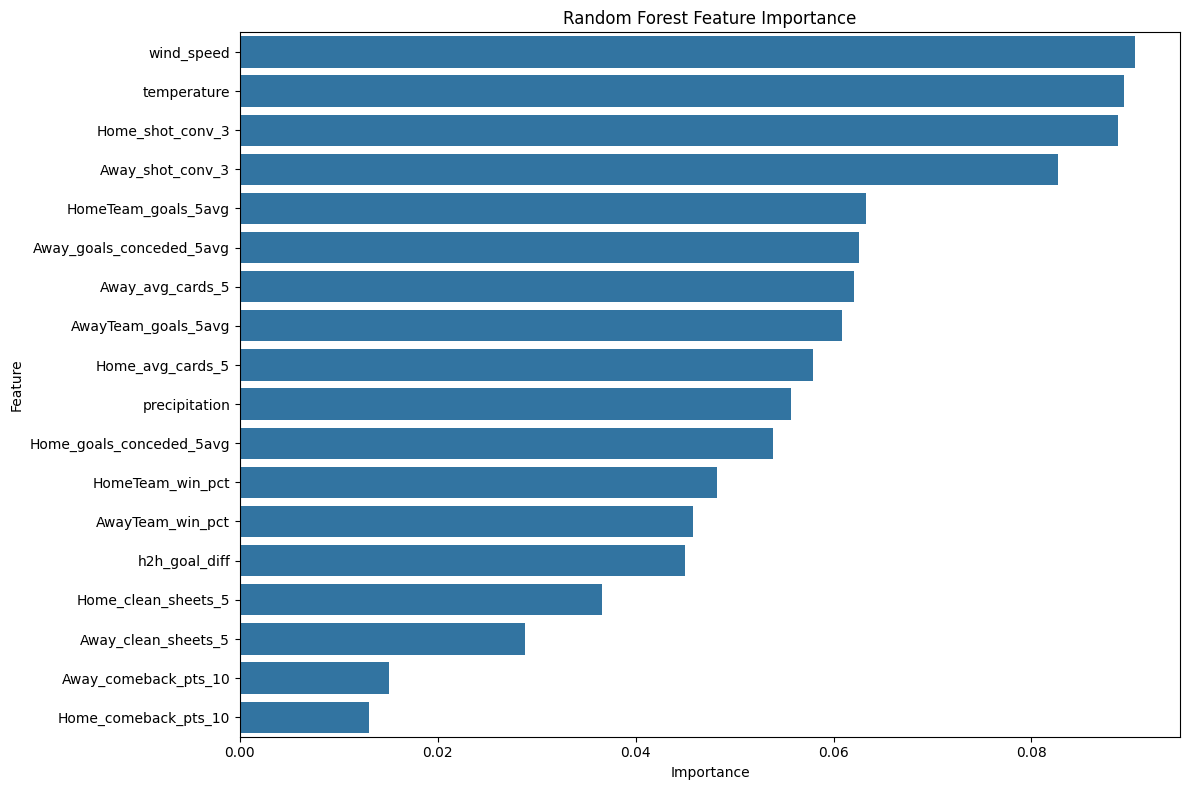

In [13]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# With weather 
rf_model2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model2.fit(X_train_weather, y_train_weather)

# Evaluate the model
rf_results = evaluate_model(rf_model, X_train, y_train, X_val, y_val)

# Evaluate the model w weather
rf_results2 = evaluate_model(rf_model2, X_train_weather, y_train_weather, X_val_weather, y_val_weather)

print("Random Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(rf_model, X_val, y_val, title='Random Forest Confusion Matrix (Validation Set)')

# Plot feature importance
rf_feature_importance = plot_feature_importance(rf_model, X_train.columns, title='Random Forest Feature Importance')

print("Random Forest Results With Weather:")
for metric, value in rf_results2.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix w weather
plot_confusion_matrix(rf_model2, X_val_weather, y_val_weather, title='Random Forest Confusion Matrix (Validation Set)')

# Plot feature importance w weather
rf_feature_importance2 = plot_feature_importance(rf_model2, X_train_weather.columns, title='Random Forest Feature Importance')


## Gradient Boosting Classifier

Gradient Boosting Results:
train_accuracy: 0.6882
train_precision: 0.7205
train_recall: 0.6882
train_f1: 0.6705
val_accuracy: 0.4184
val_precision: 0.3937
val_recall: 0.4184
val_f1: 0.3983


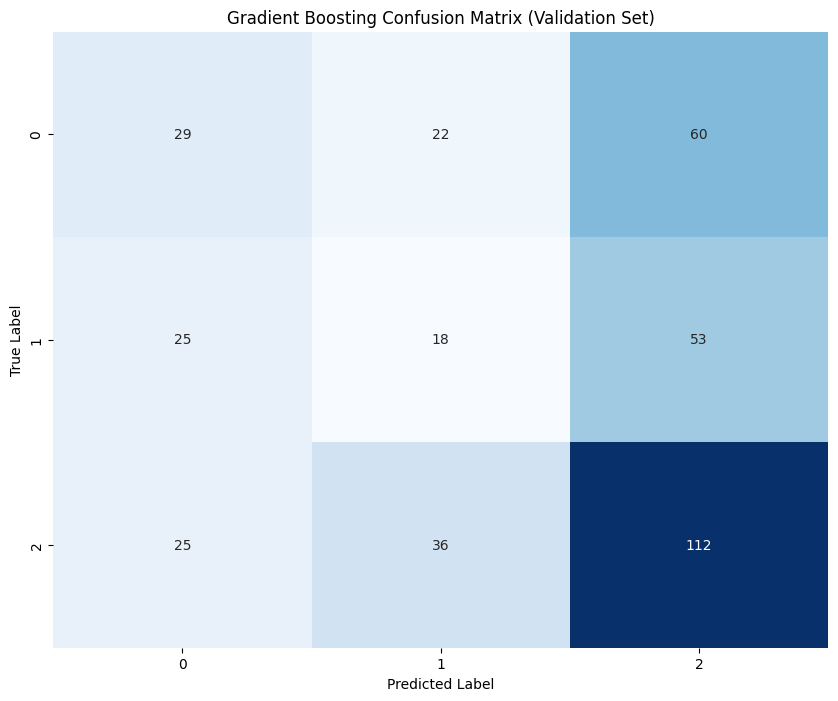

              precision    recall  f1-score   support

           A       0.37      0.26      0.31       111
           D       0.24      0.19      0.21        96
           H       0.50      0.65      0.56       173

    accuracy                           0.42       380
   macro avg       0.37      0.37      0.36       380
weighted avg       0.39      0.42      0.40       380



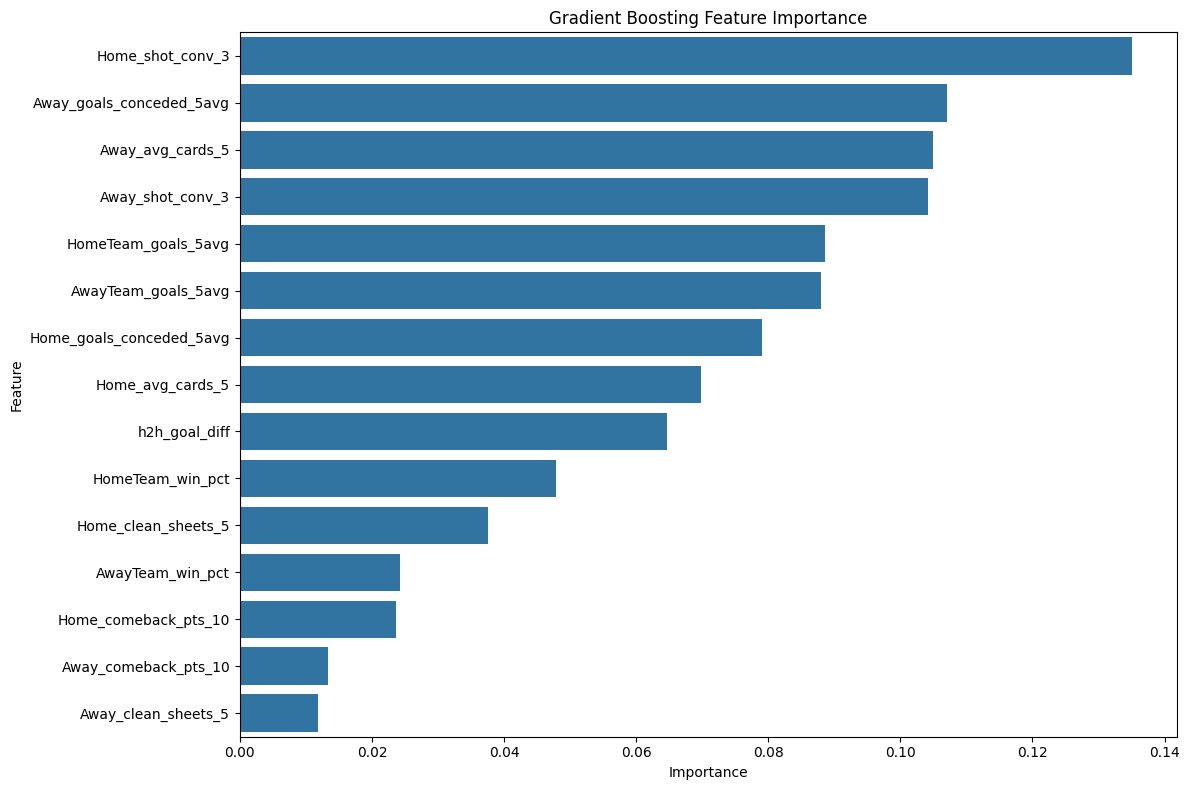

Gradient Boosting Results:
train_accuracy: 0.7211
train_precision: 0.7550
train_recall: 0.7211
train_f1: 0.7063
val_accuracy: 0.4447
val_precision: 0.4201
val_recall: 0.4447
val_f1: 0.4223


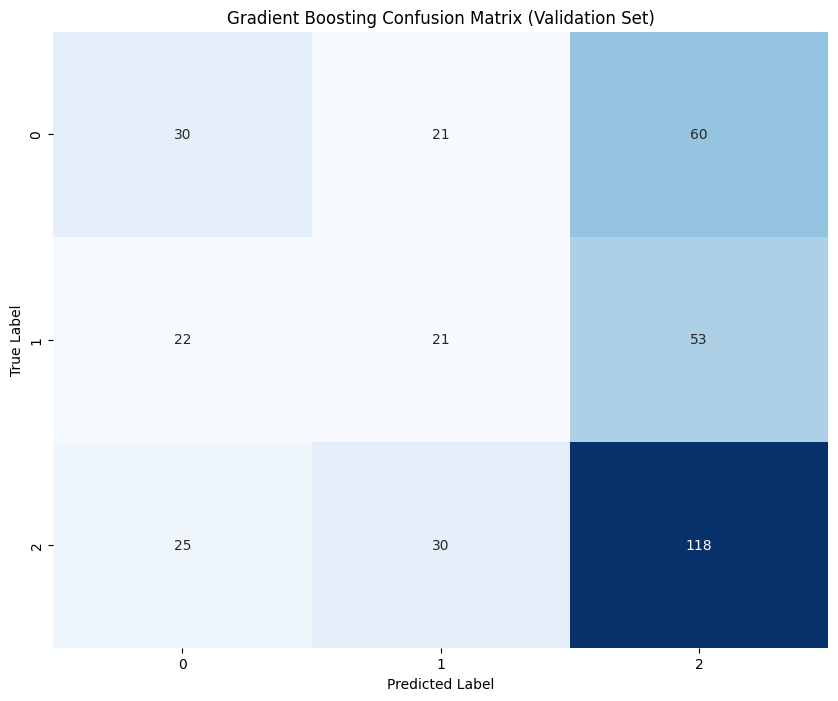

              precision    recall  f1-score   support

           A       0.39      0.27      0.32       111
           D       0.29      0.22      0.25        96
           H       0.51      0.68      0.58       173

    accuracy                           0.44       380
   macro avg       0.40      0.39      0.38       380
weighted avg       0.42      0.44      0.42       380



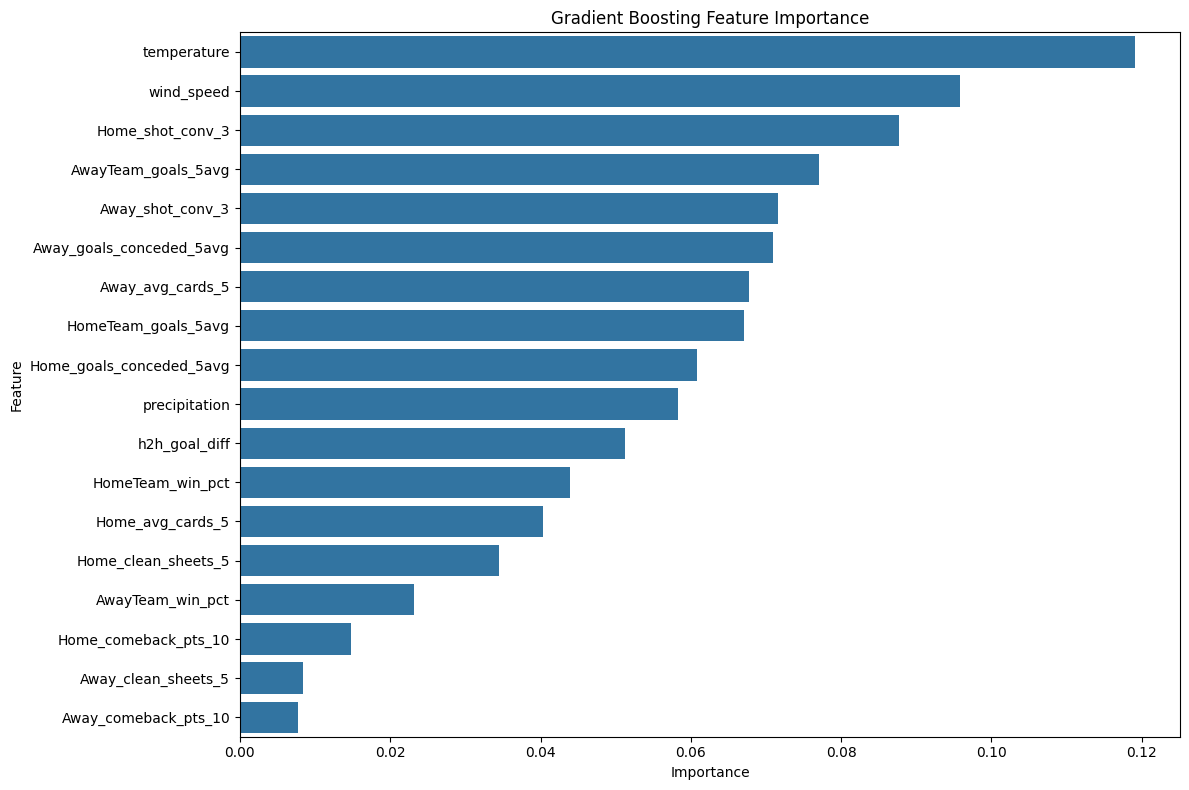

In [14]:
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate the model
gb_results = evaluate_model(gb_model, X_train, y_train, X_val, y_val)
print("Gradient Boosting Results:")
for metric, value in gb_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(gb_model, X_val, y_val, title='Gradient Boosting Confusion Matrix (Validation Set)')

# Plot feature importance
gb_feature_importance = plot_feature_importance(gb_model, X_train.columns, title='Gradient Boosting Feature Importance')

# Initialize and train Gradient Boosting model
gb_model2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model2.fit(X_train_weather, y_train_weather)

# Evaluate the model
gb_results2 = evaluate_model(gb_model2, X_train_weather, y_train_weather, X_val_weather, y_val_weather)
print("Gradient Boosting Results:")
for metric, value in gb_results2.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(gb_model2, X_val_weather, y_val_weather, title='Gradient Boosting Confusion Matrix (Validation Set)')

# Plot feature importance
gb_feature_importance2 = plot_feature_importance(gb_model2, X_train_weather.columns, title='Gradient Boosting Feature Importance')

## XGBoost Classifier

/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results (Without Weather):
train_accuracy: 0.9947
train_precision: 0.9948
train_recall: 0.9947
train_f1: 0.9947
val_accuracy: 0.4263
val_precision: 0.4205
val_recall: 0.4263
val_f1: 0.4219


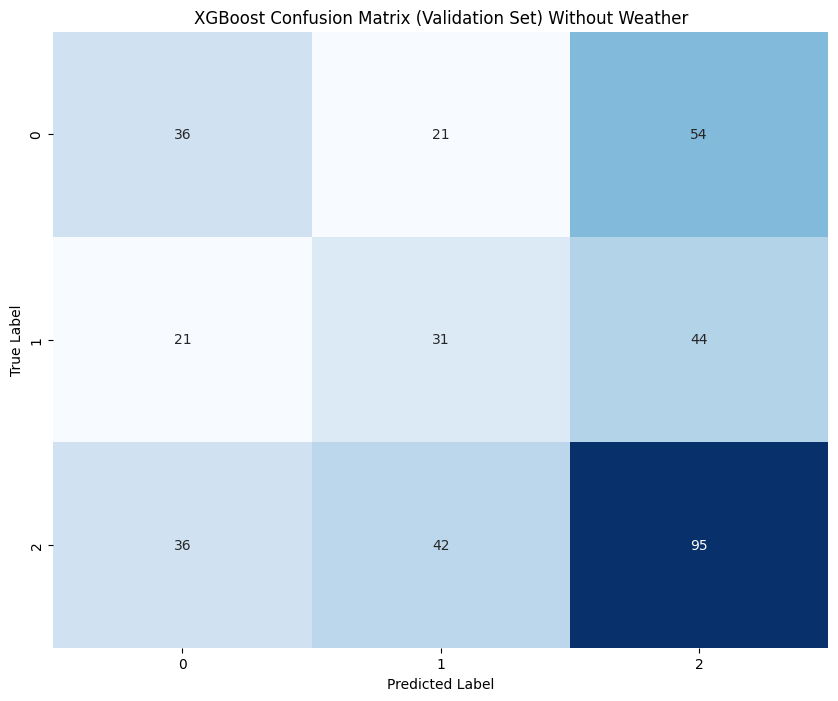

              precision    recall  f1-score   support

           0       0.39      0.32      0.35       111
           1       0.33      0.32      0.33        96
           2       0.49      0.55      0.52       173

    accuracy                           0.43       380
   macro avg       0.40      0.40      0.40       380
weighted avg       0.42      0.43      0.42       380



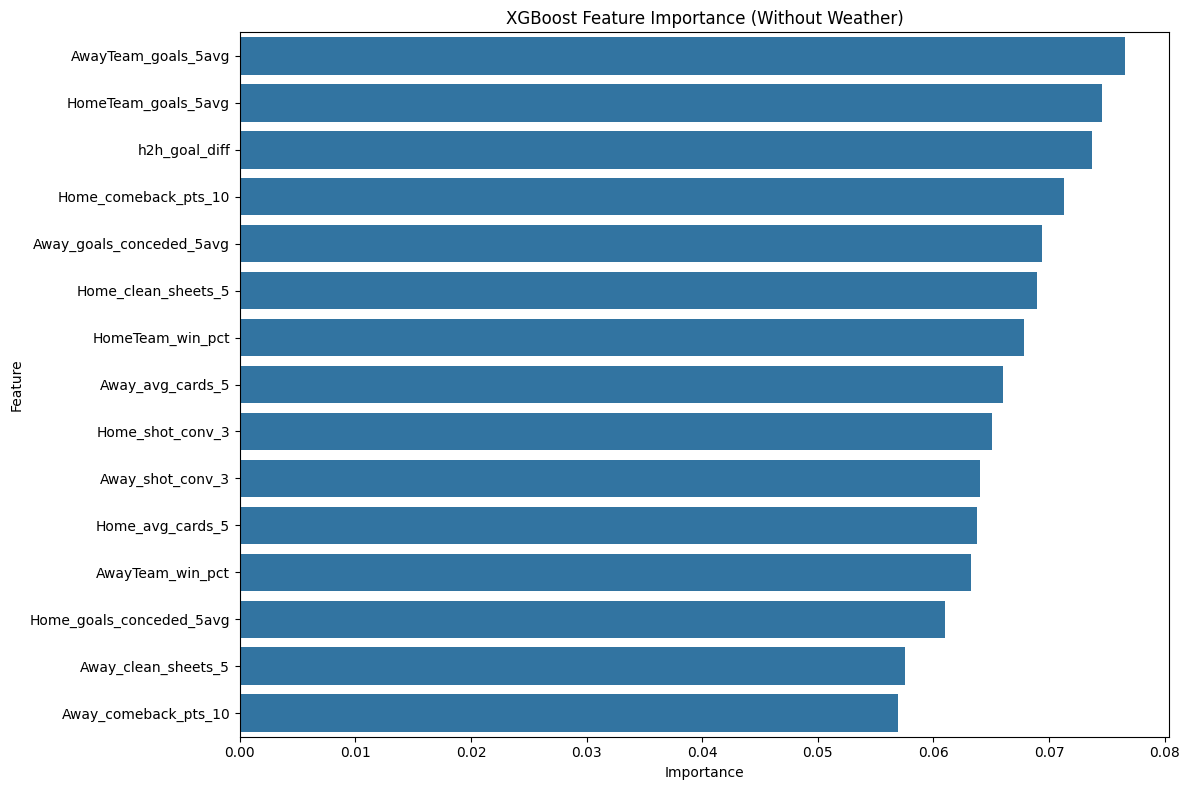

/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results (With Weather):
train_accuracy: 1.0000
train_precision: 1.0000
train_recall: 1.0000
train_f1: 1.0000
val_accuracy: 0.4237
val_precision: 0.4196
val_recall: 0.4237
val_f1: 0.4195


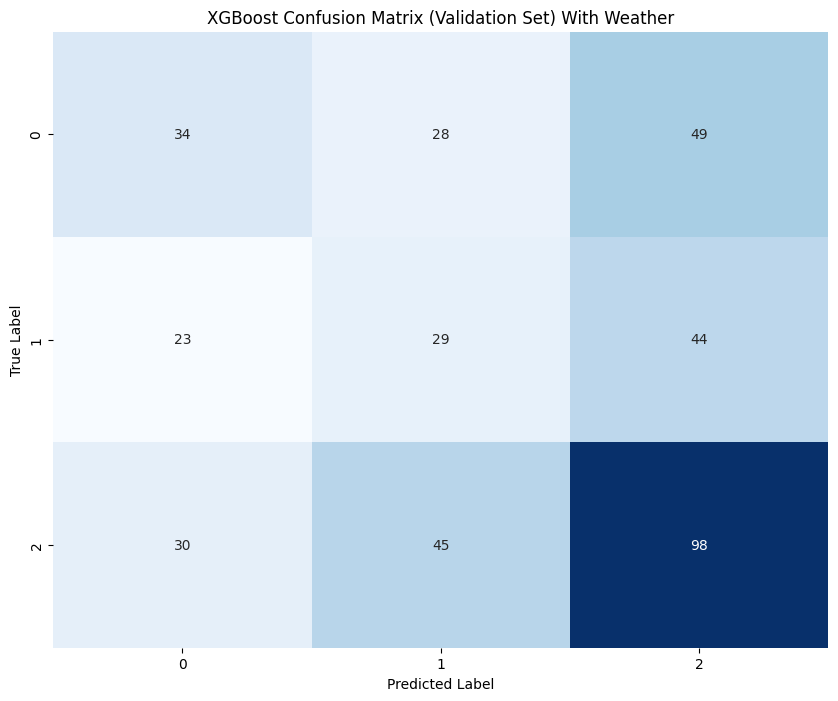

              precision    recall  f1-score   support

           0       0.39      0.31      0.34       111
           1       0.28      0.30      0.29        96
           2       0.51      0.57      0.54       173

    accuracy                           0.42       380
   macro avg       0.40      0.39      0.39       380
weighted avg       0.42      0.42      0.42       380



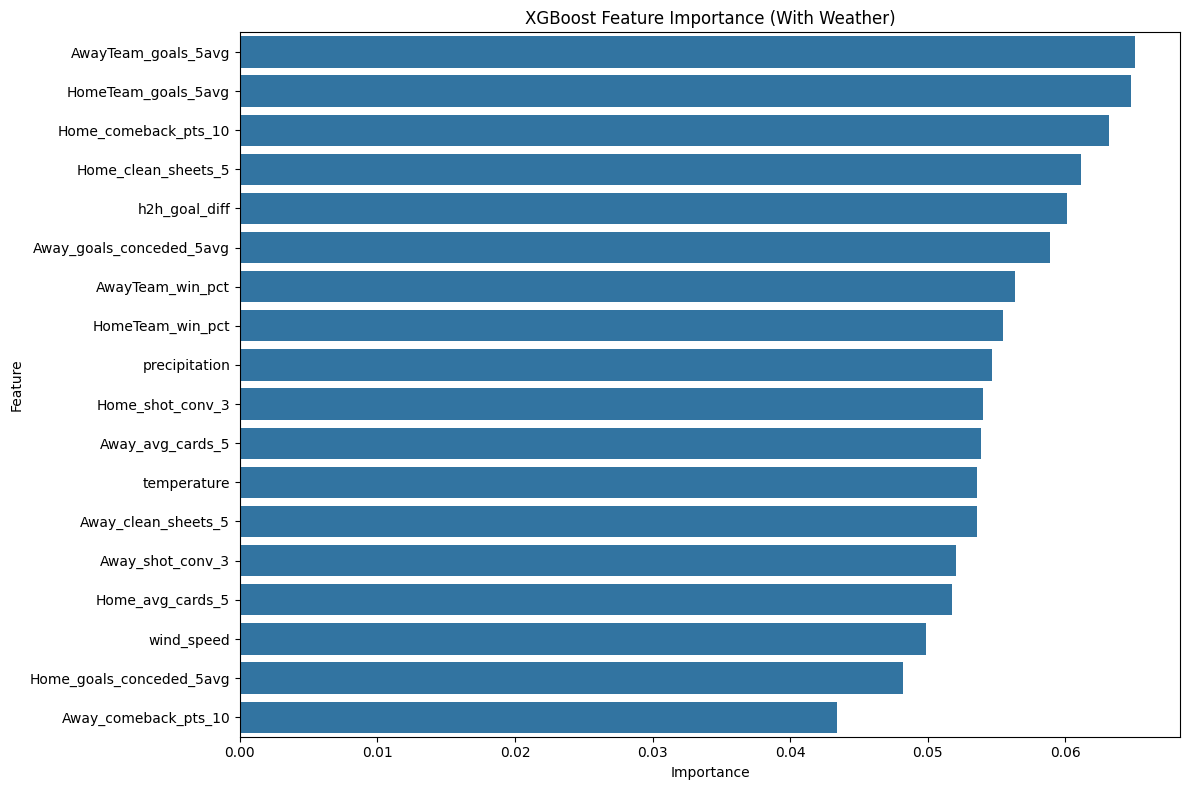

In [15]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Transform string labels to numbers for training (without weather)
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Initialize and train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_encoded)

# Evaluate the model
xgb_results = evaluate_model(xgb_model, X_train, y_train_encoded, X_val, y_val_encoded)
print("XGBoost Results (Without Weather):")
for metric, value in xgb_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(xgb_model, X_val, y_val_encoded, title='XGBoost Confusion Matrix (Validation Set) Without Weather')

# Plot feature importance
xgb_feature_importance = plot_feature_importance(xgb_model, X_train.columns, title='XGBoost Feature Importance (Without Weather)')

# Transform string labels to numbers for training (with weather)
y_train_encoded_weather = label_encoder.fit_transform(y_train_weather)
y_val_encoded_weather = label_encoder.transform(y_val_weather)

# Initialize and train XGBoost model (with weather)
xgb_model_weather = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model_weather.fit(X_train_weather, y_train_encoded_weather)

# Evaluate the model
xgb_results_weather = evaluate_model(xgb_model_weather, X_train_weather, y_train_encoded_weather, X_val_weather, y_val_encoded_weather)
print("XGBoost Results (With Weather):")
for metric, value in xgb_results_weather.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(xgb_model_weather, X_val_weather, y_val_encoded_weather, title='XGBoost Confusion Matrix (Validation Set) With Weather')

# Plot feature importance
xgb_feature_importance_weather = plot_feature_importance(xgb_model_weather, X_train_weather.columns, title='XGBoost Feature Importance (With Weather)')


## LightGBM Classifier

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 15
[LightGBM] [Info] Start training from score -1.269682
[LightGBM] [Info] Start training from score -1.340014
[LightGBM] [Info] Start training from score -0.782554
LightGBM Results:
train_accuracy: 0.9934
train_precision: 0.9935
train_recall: 0.9934
train_f1: 0.9934
val_accuracy: 0.4342
val_precision: 0.4295
val_recall: 0.4342
val_f1: 0.4303


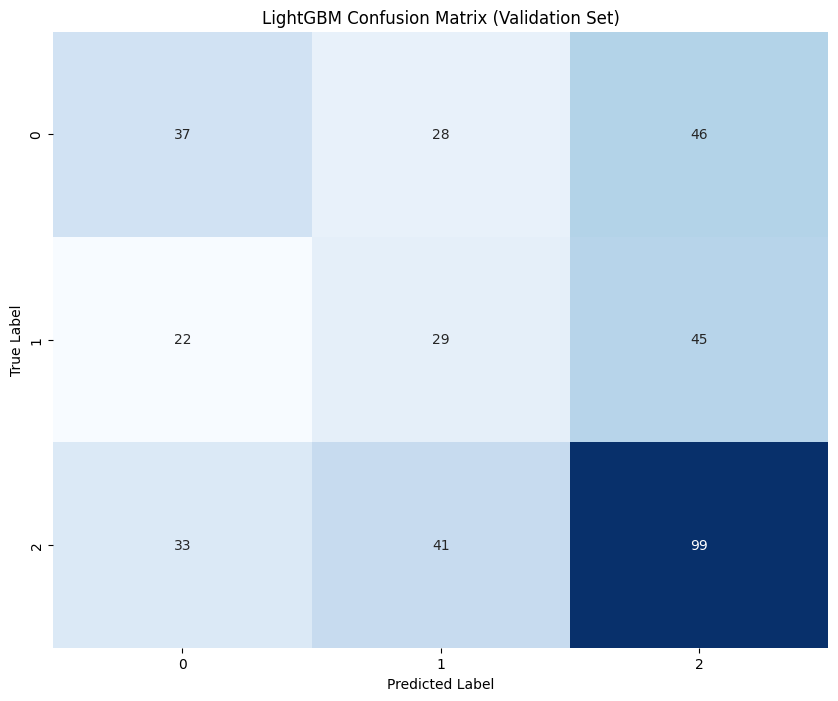

              precision    recall  f1-score   support

           A       0.40      0.33      0.36       111
           D       0.30      0.30      0.30        96
           H       0.52      0.57      0.55       173

    accuracy                           0.43       380
   macro avg       0.41      0.40      0.40       380
weighted avg       0.43      0.43      0.43       380



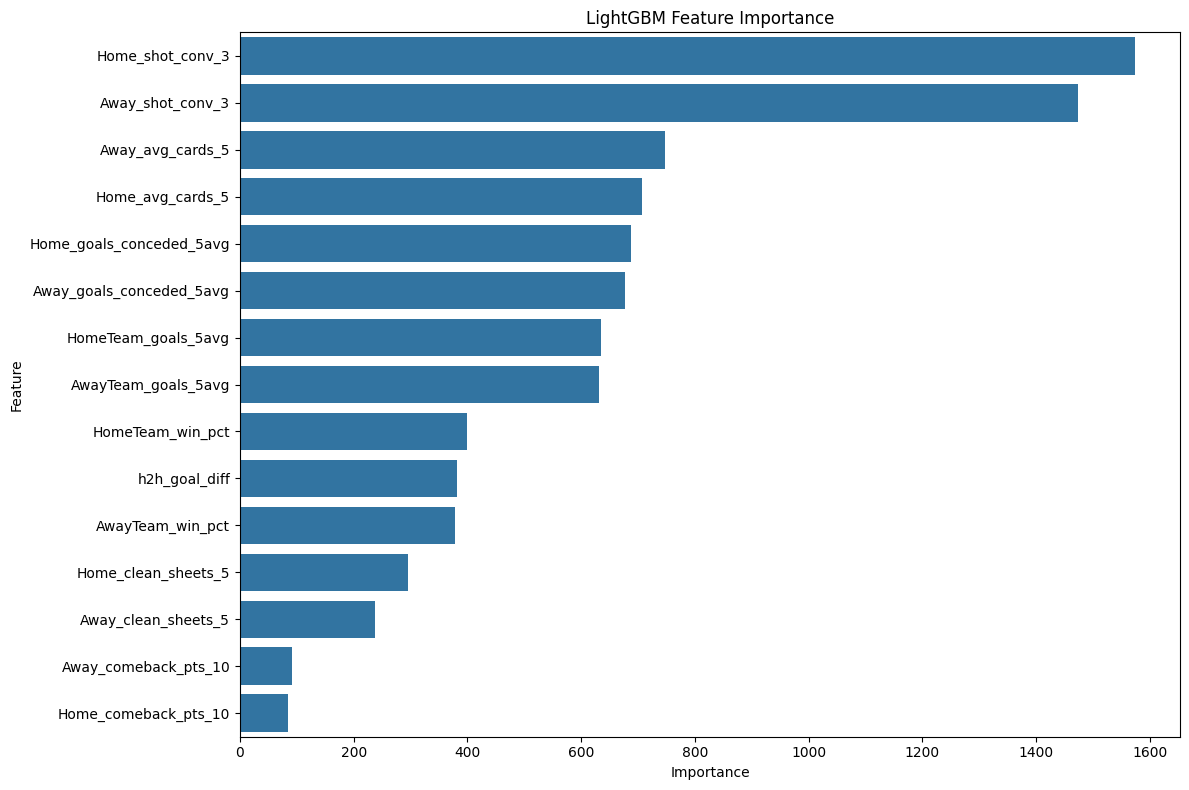

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 18
[LightGBM] [Info] Start training from score -1.269682
[LightGBM] [Info] Start training from score -1.340014
[LightGBM] [Info] Start training from score -0.782554
LightGBM Results:
train_accuracy: 0.9987
train_precision: 0.9987
train_recall: 0.9987
train_f1: 0.9987
val_accuracy: 0.4526
val_precision: 0.4465
val_recall: 0.4526
val_f1: 0.4456


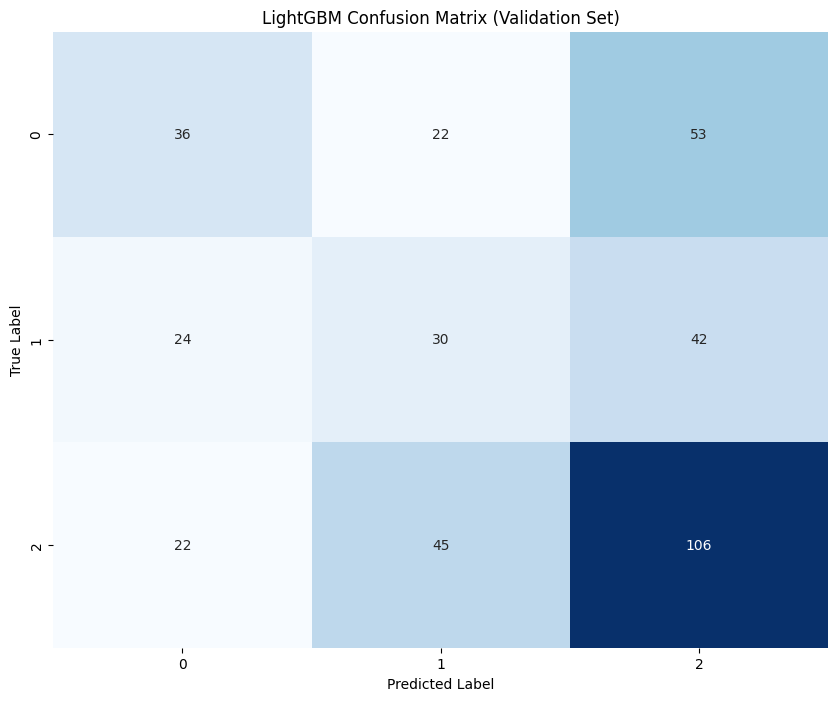

              precision    recall  f1-score   support

           A       0.44      0.32      0.37       111
           D       0.31      0.31      0.31        96
           H       0.53      0.61      0.57       173

    accuracy                           0.45       380
   macro avg       0.43      0.42      0.42       380
weighted avg       0.45      0.45      0.45       380



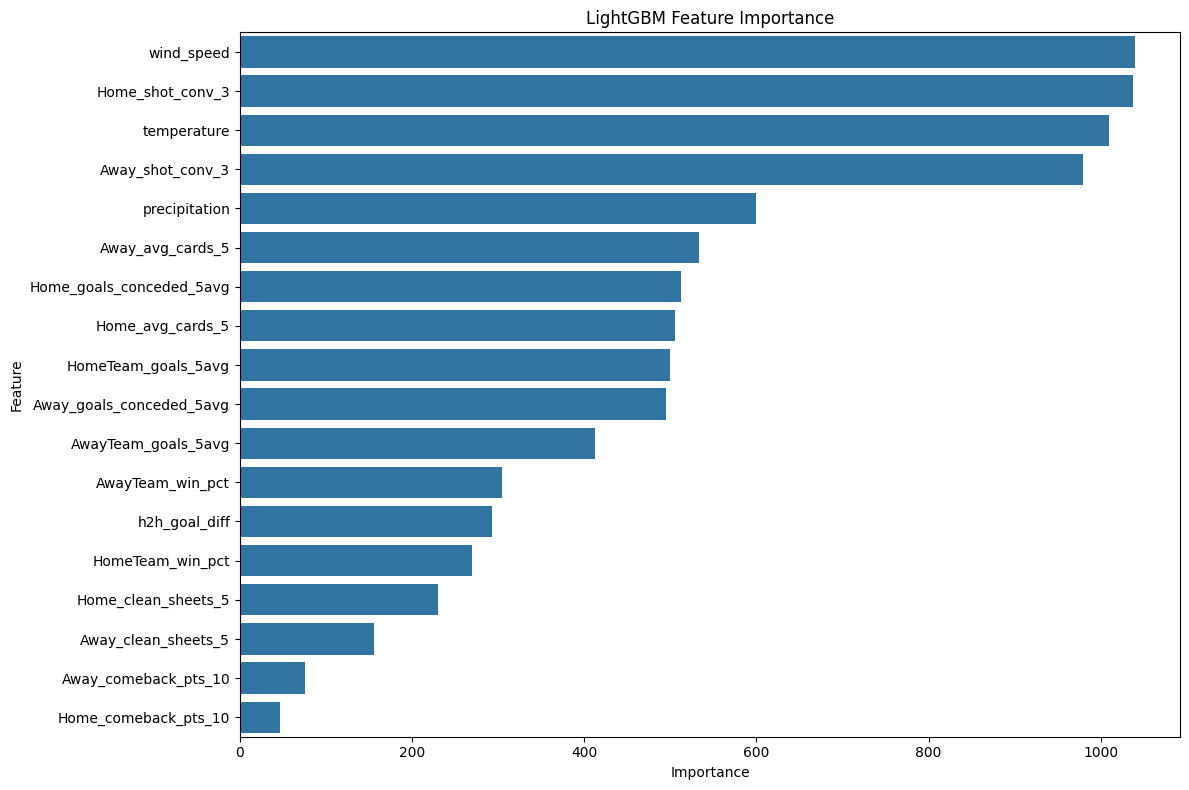

In [16]:
# Initialize and train LightGBM model
lgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)

# Evaluate the model
lgbm_results = evaluate_model(lgbm_model, X_train, y_train, X_val, y_val)
print("LightGBM Results:")
for metric, value in lgbm_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(lgbm_model, X_val, y_val, title='LightGBM Confusion Matrix (Validation Set)')

# Plot feature importance
lgbm_feature_importance = plot_feature_importance(lgbm_model, X_train.columns, title='LightGBM Feature Importance')

# Initialize and train LightGBM model
lgbm_model2 = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model2.fit(X_train_weather, y_train_weather)

# Evaluate the model
lgbm_results2 = evaluate_model(lgbm_model2, X_train_weather, y_train_weather, X_val_weather, y_val_weather)
print("LightGBM Results:")
for metric, value in lgbm_results2.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(lgbm_model2, X_val_weather, y_val_weather, title='LightGBM Confusion Matrix (Validation Set)')

# Plot feature importance
lgbm_feature_importance2 = plot_feature_importance(lgbm_model2, X_train_weather.columns, title='LightGBM Feature Importance')

## Logistic Regression

Logistic Regression Results:
train_accuracy: 0.4855
train_precision: 0.4699
train_recall: 0.4855
train_f1: 0.3946
val_accuracy: 0.4921
val_precision: 0.3675
val_recall: 0.4921
val_f1: 0.4031


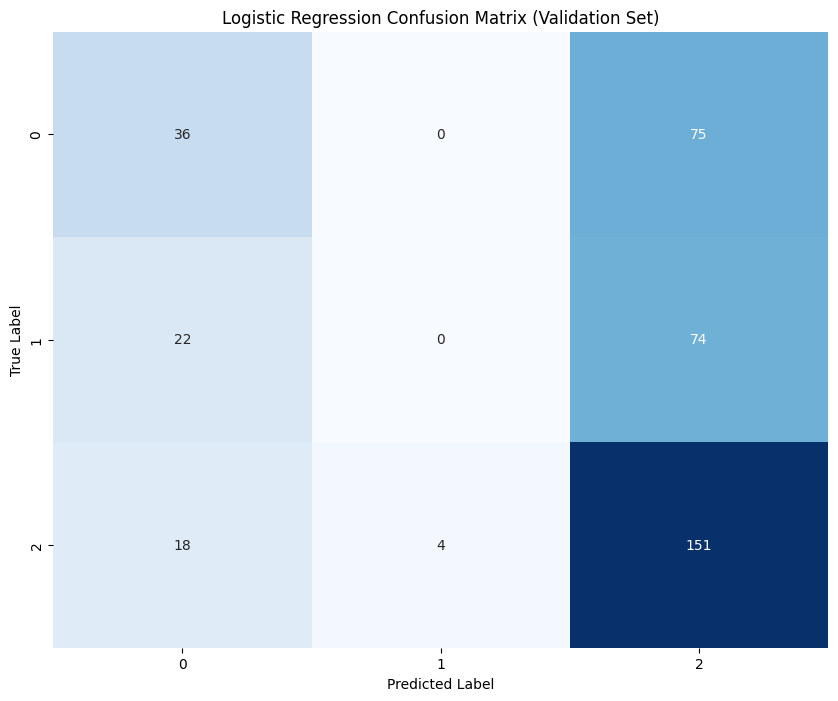

              precision    recall  f1-score   support

           A       0.47      0.32      0.39       111
           D       0.00      0.00      0.00        96
           H       0.50      0.87      0.64       173

    accuracy                           0.49       380
   macro avg       0.33      0.40      0.34       380
weighted avg       0.37      0.49      0.40       380

Logistic Regression Results:
train_accuracy: 0.4855
train_precision: 0.4561
train_recall: 0.4855
train_f1: 0.3992
val_accuracy: 0.5158
val_precision: 0.4974
val_recall: 0.5158
val_f1: 0.4449


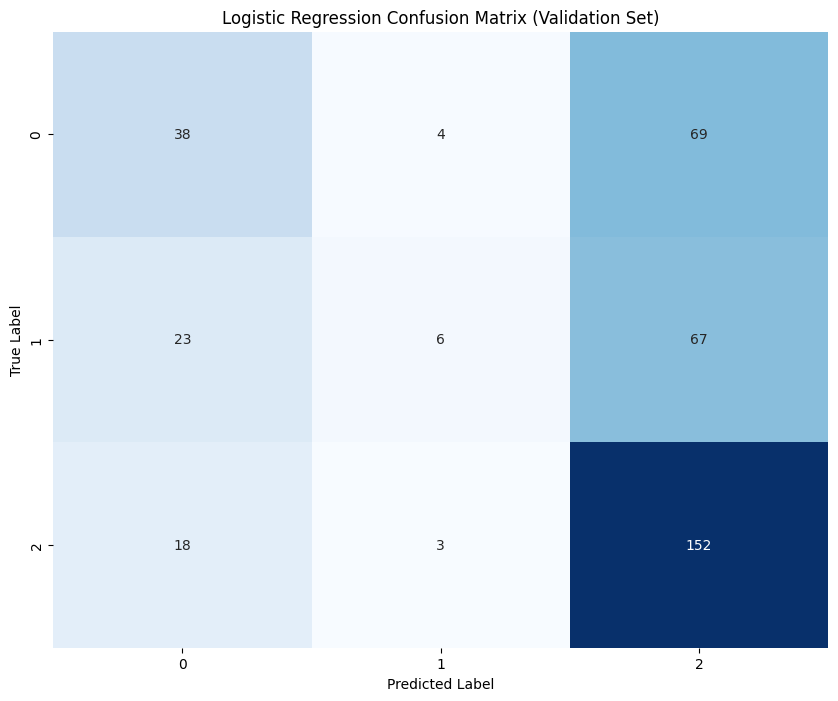

              precision    recall  f1-score   support

           A       0.48      0.34      0.40       111
           D       0.46      0.06      0.11        96
           H       0.53      0.88      0.66       173

    accuracy                           0.52       380
   macro avg       0.49      0.43      0.39       380
weighted avg       0.50      0.52      0.44       380



In [17]:
# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)

# Evaluate the model
lr_results = evaluate_model(lr_model, X_train, y_train, X_val, y_val)
print("Logistic Regression Results:")
for metric, value in lr_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(lr_model, X_val, y_val, title='Logistic Regression Confusion Matrix (Validation Set)')

# Initialize and train Logistic Regression model
lr_model2 = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model2.fit(X_train_weather, y_train_weather)

# Evaluate the model
lr_results2 = evaluate_model(lr_model2, X_train_weather, y_train_weather, X_val_weather, y_val_weather)
print("Logistic Regression Results:")
for metric, value in lr_results2.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(lr_model2, X_val_weather, y_val_weather, title='Logistic Regression Confusion Matrix (Validation Set)')

## Support Vector Machine

SVM Results:
train_accuracy: 0.4974
train_precision: 0.6399
train_recall: 0.4974
train_f1: 0.3855
val_accuracy: 0.4842
val_precision: 0.3565
val_recall: 0.4842
val_f1: 0.3749


/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


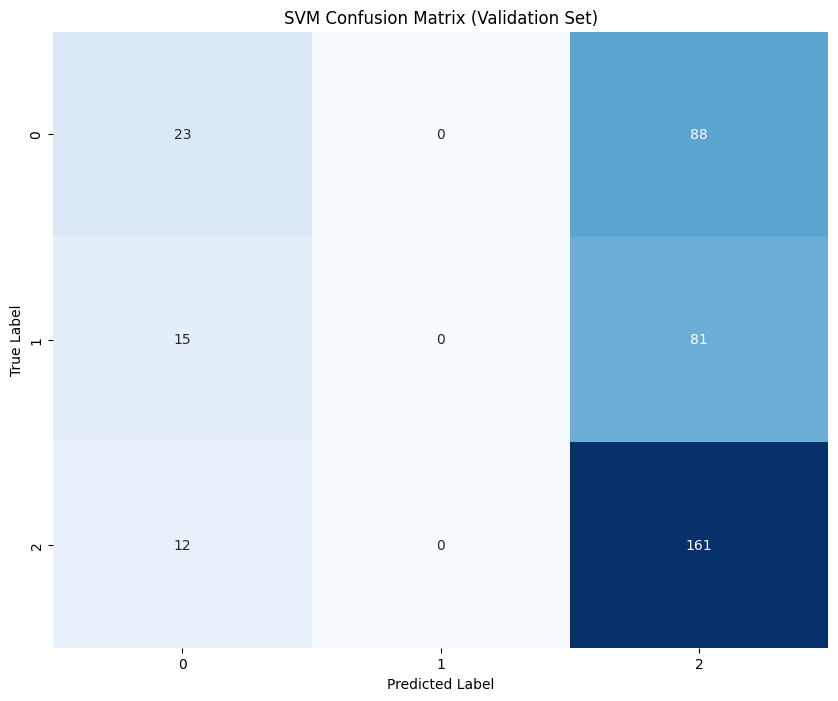

/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

              precision    recall  f1-score   support

           A       0.46      0.21      0.29       111
           D       0.00      0.00      0.00        96
           H       0.49      0.93      0.64       173

    accuracy                           0.48       380
   macro avg       0.32      0.38      0.31       380
weighted avg       0.36      0.48      0.37       380

SVM Results:
train_accuracy: 0.4572
train_precision: 0.2091
train_recall: 0.4572
train_f1: 0.2869
val_accuracy: 0.4553
val_precision: 0.2073
val_recall: 0.4553
val_f1: 0.2848


/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


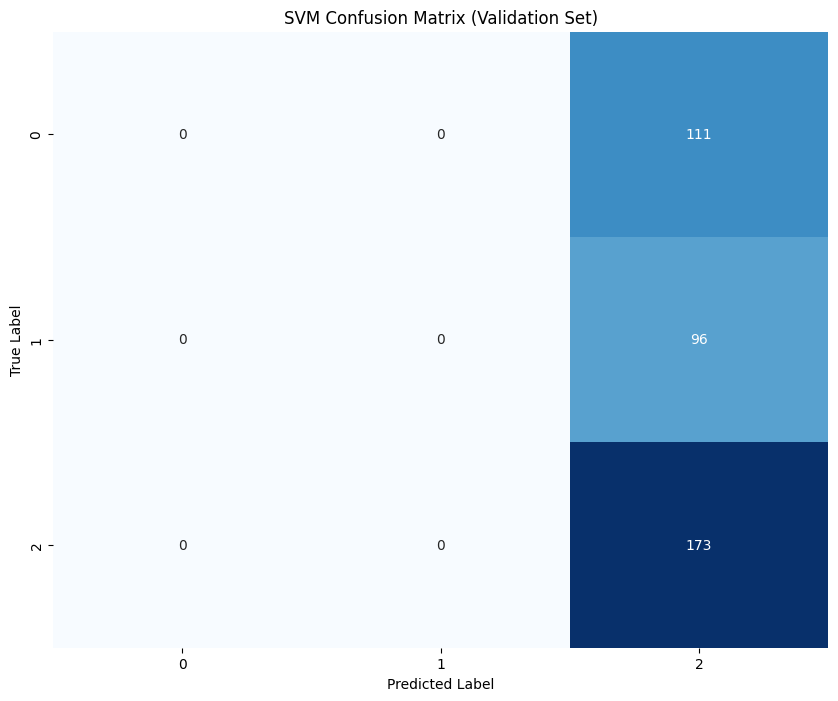

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       111
           D       0.00      0.00      0.00        96
           H       0.46      1.00      0.63       173

    accuracy                           0.46       380
   macro avg       0.15      0.33      0.21       380
weighted avg       0.21      0.46      0.28       380



/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

In [18]:
# Initialize and train SVM model
# Note: SVM can be slow on large datasets, so we'll use a smaller subset if needed
if X_train.shape[0] > 10000:
    print("SVM might be slow on this dataset. Consider using a smaller subset or different model.")

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the model
svm_results = evaluate_model(svm_model, X_train, y_train, X_val, y_val)
print("SVM Results:")
for metric, value in svm_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(svm_model, X_val, y_val, title='SVM Confusion Matrix (Validation Set)')

# Initialize and train SVM model
# Note: SVM can be slow on large datasets, so we'll use a smaller subset if needed
if X_train_weather.shape[0] > 10000:
    print("SVM might be slow on this dataset. Consider using a smaller subset or different model.")

svm_model2 = SVC(probability=True, random_state=42)
svm_model2.fit(X_train_weather, y_train_weather)

# Evaluate the model
svm_results2 = evaluate_model(svm_model2, X_train_weather, y_train_weather, X_val_weather, y_val_weather)
print("SVM Results:")
for metric, value in svm_results2.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(svm_model2, X_val_weather, y_val_weather, title='SVM Confusion Matrix (Validation Set)')

## Neural Network (MLP Classifier)

Neural Network Results:
train_accuracy: 0.9355
train_precision: 0.9358
train_recall: 0.9355
train_f1: 0.9354
val_accuracy: 0.4316
val_precision: 0.4276
val_recall: 0.4316
val_f1: 0.4294


/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


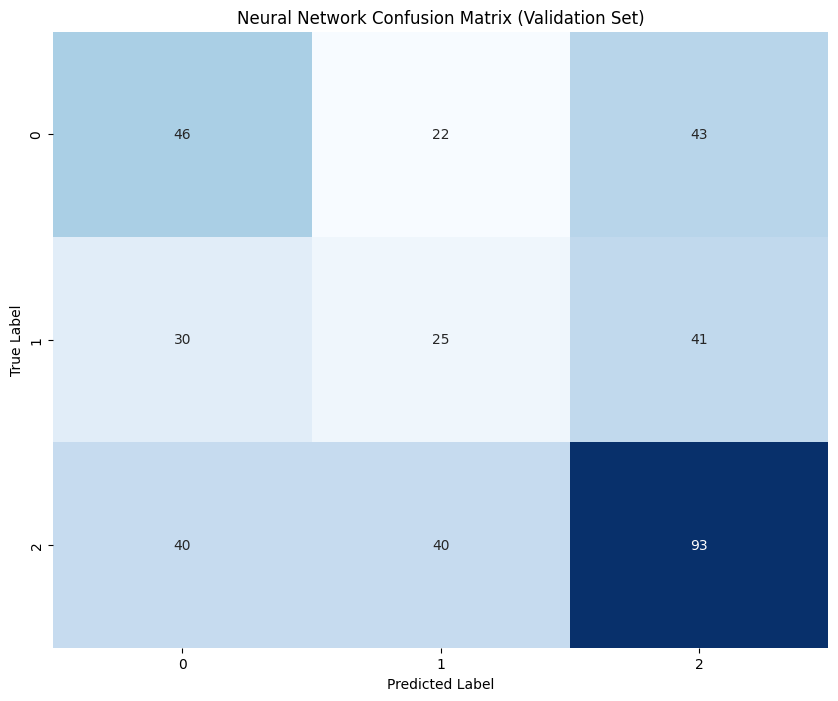

              precision    recall  f1-score   support

           A       0.40      0.41      0.41       111
           D       0.29      0.26      0.27        96
           H       0.53      0.54      0.53       173

    accuracy                           0.43       380
   macro avg       0.40      0.40      0.40       380
weighted avg       0.43      0.43      0.43       380

Neural Network Results:
train_accuracy: 0.8053
train_precision: 0.8099
train_recall: 0.8053
train_f1: 0.8018
val_accuracy: 0.4026
val_precision: 0.3816
val_recall: 0.4026
val_f1: 0.3851


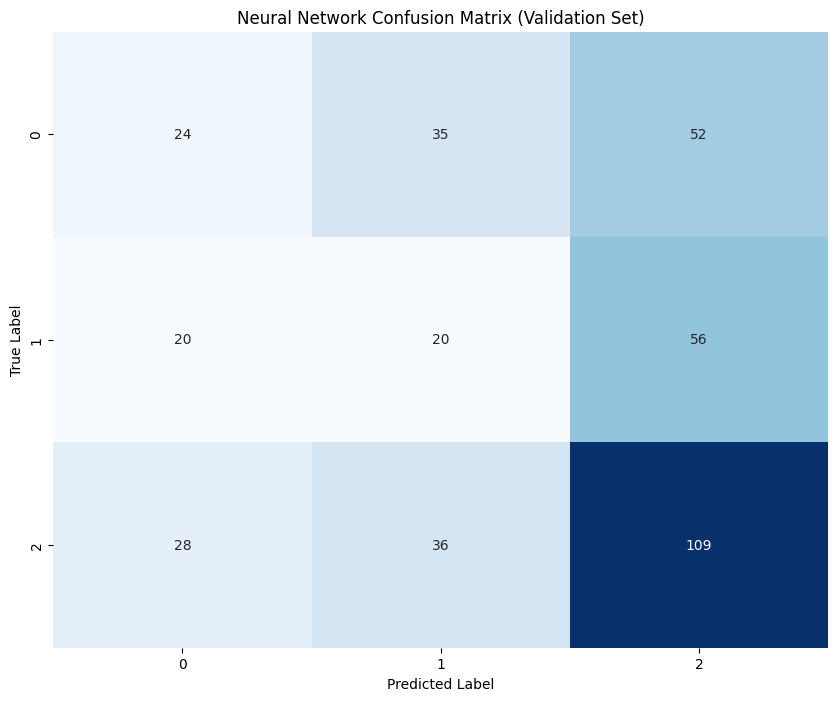

              precision    recall  f1-score   support

           A       0.33      0.22      0.26       111
           D       0.22      0.21      0.21        96
           H       0.50      0.63      0.56       173

    accuracy                           0.40       380
   macro avg       0.35      0.35      0.35       380
weighted avg       0.38      0.40      0.39       380



In [19]:
# Initialize and train Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

# Evaluate the model
nn_results = evaluate_model(nn_model, X_train, y_train, X_val, y_val)
print("Neural Network Results:")
for metric, value in nn_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(nn_model, X_val, y_val, title='Neural Network Confusion Matrix (Validation Set)')

# Initialize and train Neural Network model
nn_model2 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model2.fit(X_train_weather, y_train_weather)

# Evaluate the model
nn_results2 = evaluate_model(nn_model2, X_train_weather, y_train_weather, X_val_weather, y_val_weather)
print("Neural Network Results:")
for metric, value in nn_results2.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(nn_model2, X_val_weather, y_val_weather, title='Neural Network Confusion Matrix (Validation Set)')

CatBoost Results:
train_accuracy: 0.9526
train_precision: 0.9536
train_recall: 0.9526
train_f1: 0.9525
val_accuracy: 0.4026
val_precision: 0.3979
val_recall: 0.4026
val_f1: 0.3996


/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


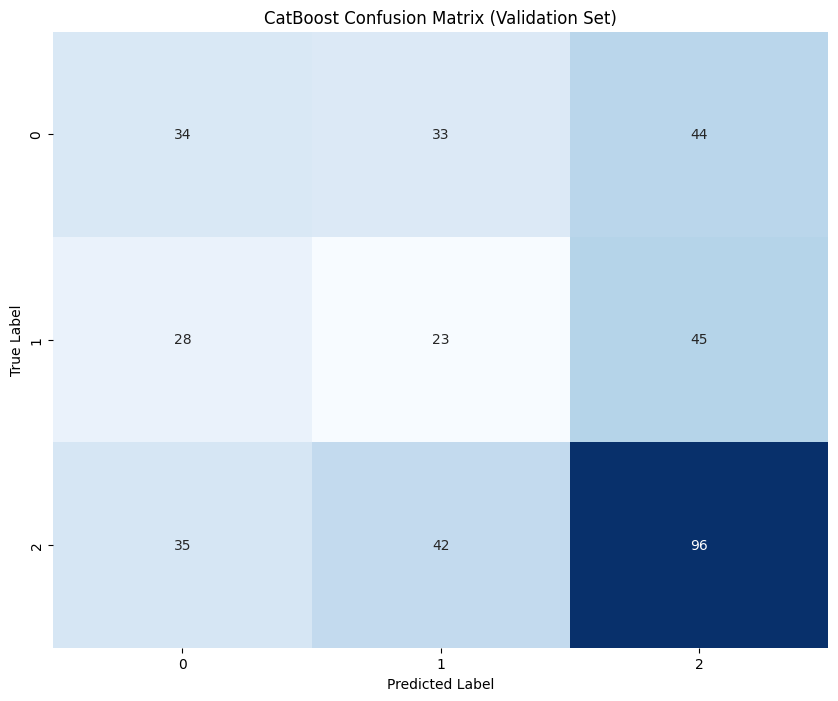

              precision    recall  f1-score   support

           0       0.35      0.31      0.33       111
           1       0.23      0.24      0.24        96
           2       0.52      0.55      0.54       173

    accuracy                           0.40       380
   macro avg       0.37      0.37      0.37       380
weighted avg       0.40      0.40      0.40       380



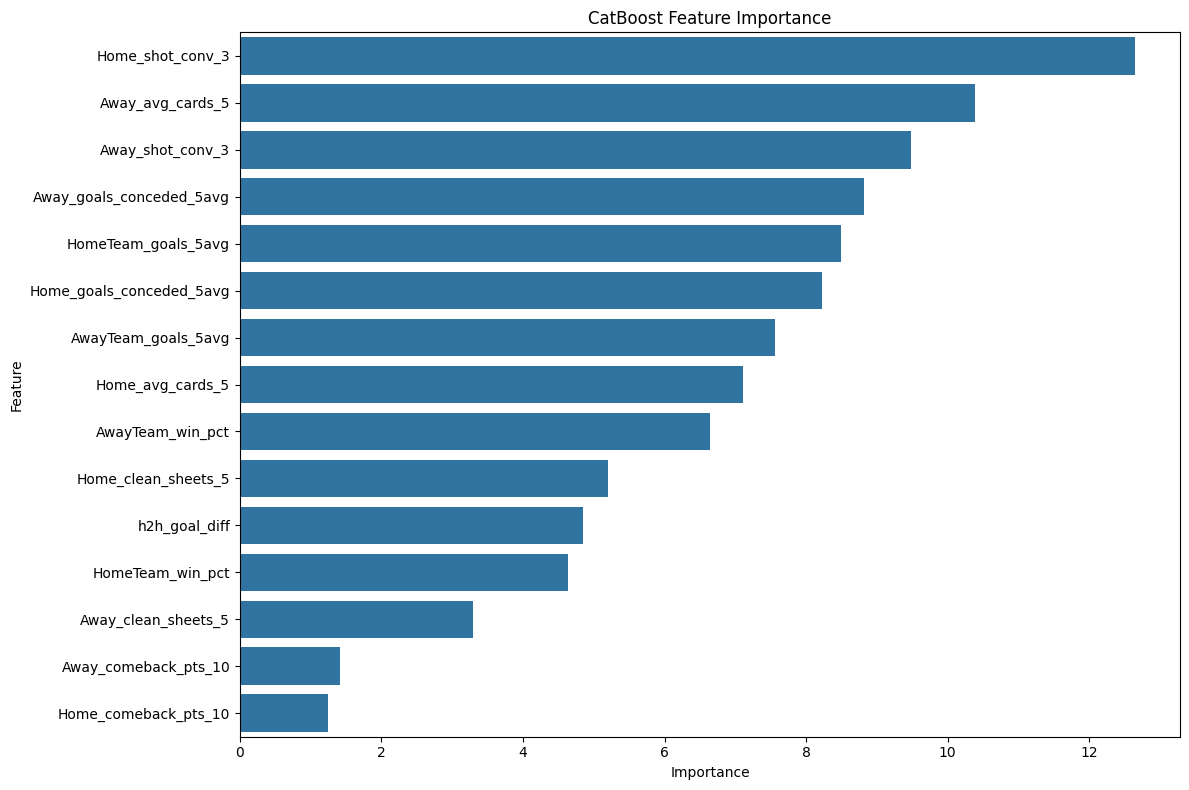

CatBoost Results (With Weather):
train_accuracy: 0.9822
train_precision: 0.9824
train_recall: 0.9822
train_f1: 0.9822
val_accuracy: 0.3921
val_precision: 0.3821
val_recall: 0.3921
val_f1: 0.3828


/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jakobrelling/Documents/skole/PUC_2/Empirisk/Empirical-Research/myenv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


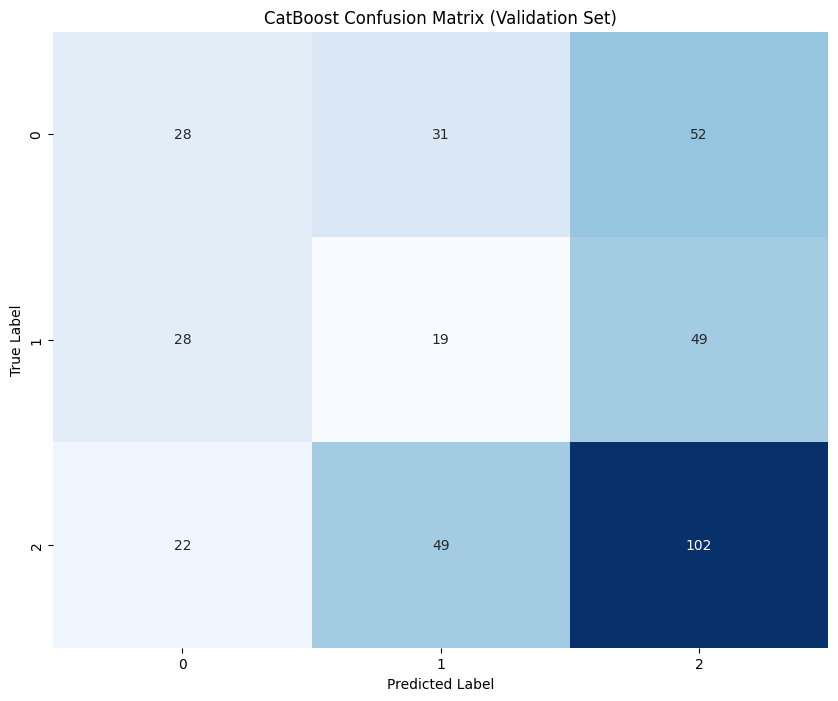

              precision    recall  f1-score   support

           0       0.36      0.25      0.30       111
           1       0.19      0.20      0.19        96
           2       0.50      0.59      0.54       173

    accuracy                           0.39       380
   macro avg       0.35      0.35      0.34       380
weighted avg       0.38      0.39      0.38       380



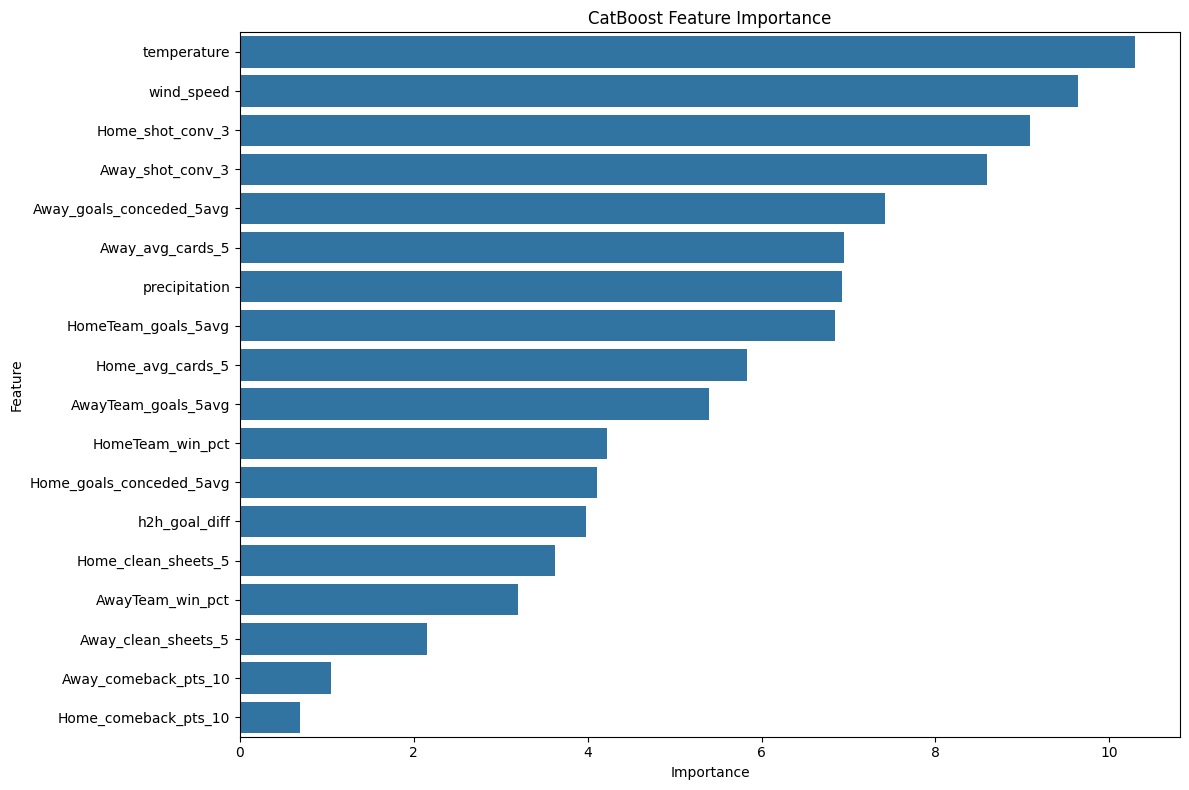

,Feature,Importance
15,temperature,10.297901
16,wind_speed,9.636490
9,Home_shot_conv_3,9.089847
10,Away_shot_conv_3,8.589740
6,Away_goals_conceded_5avg,7.421091
12,Away_avg_cards_5,6.948579
17,precipitation,6.926297
0,HomeTeam_goals_5avg,6.841053
11,Home_avg_cards_5,5.831727
1,AwayTeam_goals_5avg,5.390953


In [35]:
def evaluate_catboost(model, X_train, y_train_encoded, X_val, y_val_encoded, X_test=None, y_test=None):
    """Evaluate a CatBoost model using helper functions."""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Decode predictions back to original labels for comparison
    y_train_pred_original = label_encoder.inverse_transform(y_train_pred)
    y_val_pred_original = label_encoder.inverse_transform(y_val_pred)
    
    y_train_original = label_encoder.inverse_transform(y_train_encoded)
    y_val_original = label_encoder.inverse_transform(y_val_encoded)

    # Evaluate using original decoded labels
    train_metrics = {
        "accuracy": accuracy_score(y_train_original, y_train_pred_original),
        "precision": precision_score(y_train_original, y_train_pred_original, average='weighted'),
        "recall": recall_score(y_train_original, y_train_pred_original, average='weighted'),
        "f1_score": f1_score(y_train_original, y_train_pred_original, average='weighted'),
    }
    val_metrics = {
        "accuracy": accuracy_score(y_val_original, y_val_pred_original),
        "precision": precision_score(y_val_original, y_val_pred_original, average='weighted'),
        "recall": recall_score(y_val_original, y_val_pred_original, average='weighted'),
        "f1_score": f1_score(y_val_original, y_val_pred_original, average='weighted'),
    }

    # Create results dictionary in the same format as the previous evaluation function
    results = {
        'train_accuracy': train_metrics["accuracy"],
        'train_precision': train_metrics["precision"],
        'train_recall': train_metrics["recall"],
        'train_f1': train_metrics["f1_score"],
        'val_accuracy': val_metrics["accuracy"],
        'val_precision': val_metrics["precision"],
        'val_recall': val_metrics["recall"],
        'val_f1': val_metrics["f1_score"]
    }

    # Test set performance (if provided)
    if X_test is not None and y_test is not None:
        y_test_pred = model.predict(X_test)
        y_test_pred_original = label_encoder.inverse_transform(y_test_pred)
        y_test_original = label_encoder.inverse_transform(y_test)

        test_metrics = {
            "accuracy": accuracy_score(y_test_original, y_test_pred_original),
            "precision": precision_score(y_test_original, y_test_pred_original, average='weighted'),
            "recall": recall_score(y_test_original, y_test_pred_original, average='weighted'),
            "f1_score": f1_score(y_test_original, y_test_pred_original, average='weighted'),
        }

        results.update({
            'test_accuracy': test_metrics["accuracy"],
            'test_precision': test_metrics["precision"],
            'test_recall': test_metrics["recall"],
            'test_f1': test_metrics["f1_score"]
        })

    return results

# Initialize and train CatBoost model
catboost_model = CatBoostClassifier(iterations=100, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train_encoded)

# Evaluate the CatBoost model
catboost_results = evaluate_catboost(catboost_model, X_train, y_train_encoded, X_val, y_val_encoded)
print("CatBoost Results:")
for metric, value in catboost_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(catboost_model, X_val, y_val_encoded, title='CatBoost Confusion Matrix (Validation Set)')

# Plot feature importance
plot_feature_importance(catboost_model, X_train.columns, title='CatBoost Feature Importance')

# ----- With Weather Data -----

# Label Encoding for weather data
y_train_encoded_weather = label_encoder.fit_transform(y_train_weather)
y_val_encoded_weather = label_encoder.transform(y_val_weather)

# Initialize and train CatBoost model with weather data
catboost_model_weather = CatBoostClassifier(iterations=100, random_seed=42, verbose=0)
catboost_model_weather.fit(X_train_weather, y_train_encoded_weather)

# Evaluate the CatBoost model with weather data
catboost_results_weather = evaluate_catboost(catboost_model_weather, X_train_weather, y_train_encoded_weather, X_val_weather, y_val_encoded_weather)
print("CatBoost Results (With Weather):")
for metric, value in catboost_results_weather.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(catboost_model_weather, X_val_weather, y_val_encoded_weather, title='CatBoost Confusion Matrix (Validation Set)')

# Plot feature importance
plot_feature_importance(catboost_model_weather, X_train_weather.columns, title='CatBoost Feature Importance')


## Model Comparison

<Figure size 1400x800 with 0 Axes>

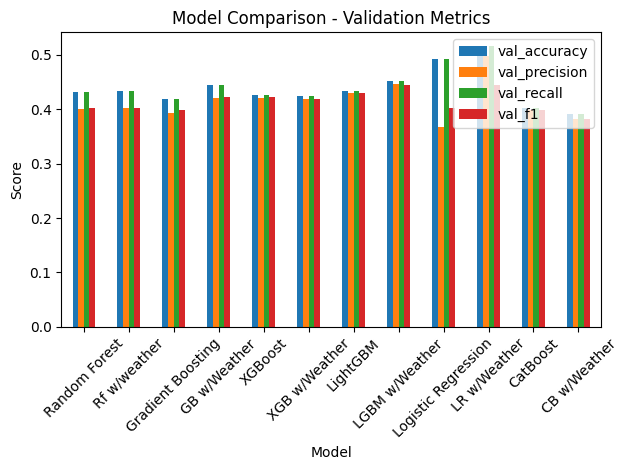

,train_accuracy,train_precision,train_recall,train_f1,val_accuracy,val_precision,val_recall,val_f1
Random Forest,0.995395,0.995441,0.995395,0.995396,0.431579,0.400767,0.431579,0.401874
Rf w/weather,1.000000,1.000000,1.000000,1.000000,0.434211,0.402241,0.434211,0.401935
Gradient Boosting,0.688158,0.720510,0.688158,0.670526,0.418421,0.393682,0.418421,0.398274
GB w/Weather,0.721053,0.755046,0.721053,0.706253,0.444737,0.420050,0.444737,0.422329
XGBoost,0.994737,0.994778,0.994737,0.994736,0.426316,0.420481,0.426316,0.421872
XGB w/Weather,1.000000,1.000000,1.000000,1.000000,0.423684,0.419573,0.423684,0.419464
LightGBM,0.993421,0.993514,0.993421,0.993424,0.434211,0.429452,0.434211,0.430336
LGBM w/Weather,0.998684,0.998688,0.998684,0.998684,0.452632,0.446464,0.452632,0.445574
Logistic Regression,0.485526,0.469885,0.485526,0.394598,0.492105,0.367515,0.492105,0.403144
LR w/Weather,0.485526,0.456111,0.485526,0.399159,0.515789,0.497383,0.515789,0.444872


In [36]:
# Collect all results
all_results = {
    'Random Forest': rf_results,
    'Rf w/weather': rf_results2,
    'Gradient Boosting': gb_results,
    'GB w/Weather': gb_results2,
    'XGBoost': xgb_results,
    'XGB w/Weather': xgb_results_weather,
    'LightGBM': lgbm_results,
    'LGBM w/Weather': lgbm_results2,
    'Logistic Regression': lr_results,
    'LR w/Weather': lr_results2,
    'CatBoost': catboost_results,
    'CB w/Weather': catboost_results_weather
    # 'SVM': svm_results,
    # 'SVM /Weather': svm_results2,
    # 'Neural Network': nn_results,
    # 'NN w/Weather': nn_results2
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(all_results).T

# Plot validation metrics for comparison
plt.figure(figsize=(14, 8))
comparison_df[['val_accuracy', 'val_precision', 'val_recall', 'val_f1']].plot(kind='bar')
plt.title('Model Comparison - Validation Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Display the comparison table
comparison_df

## Hyperparameter Tuning for Best Model

Best model based on validation F1 score: Gradient Boosting
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.2}
Best cross-validation score: 0.4173

Tuned Model Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4289
val_precision: 0.4074
val_recall: 0.4289
val_f1: 0.4137


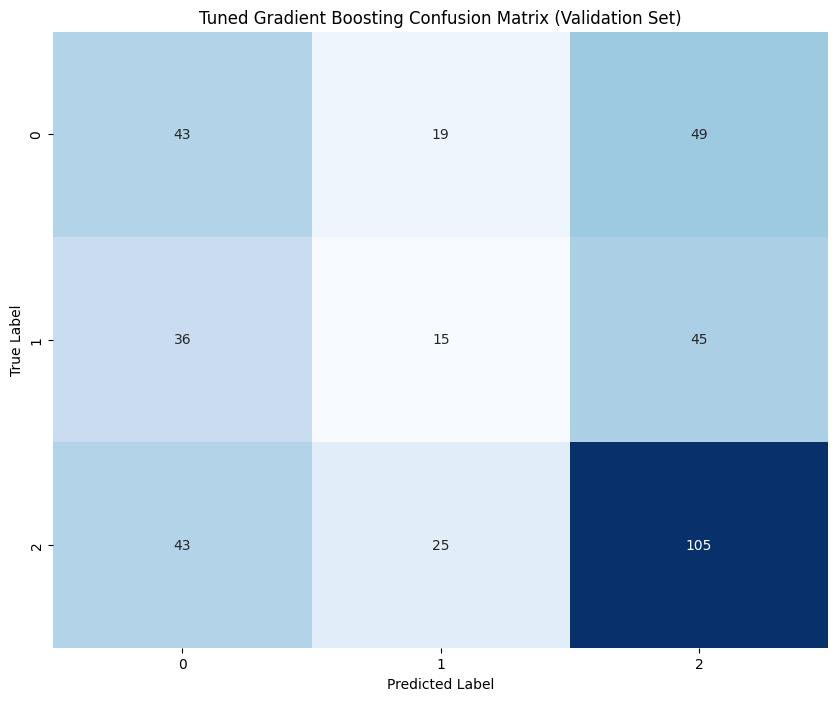

              precision    recall  f1-score   support

           A       0.35      0.39      0.37       111
           D       0.25      0.16      0.19        96
           H       0.53      0.61      0.56       173

    accuracy                           0.43       380
   macro avg       0.38      0.38      0.38       380
weighted avg       0.41      0.43      0.41       380



In [15]:
# Identify the best model based on validation F1 score
best_model_name = comparison_df['val_f1'].idxmax()
print(f"Best model based on validation F1 score: {best_model_name}")

# Define hyperparameter grid for the best model
if best_model_name == 'Random Forest':
    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    model = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'XGBoost':
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 0.9]
    }
elif best_model_name == 'LightGBM':
    model = lgb.LGBMClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 100]
    }
elif best_model_name == 'Logistic Regression':
    model = LogisticRegression(random_state=42, max_iter=1000)
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
elif best_model_name == 'SVM':
    model = SVC(probability=True, random_state=42)
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }
elif best_model_name == 'Neural Network':
    model = MLPClassifier(random_state=42, max_iter=500)
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    model, param_grid, n_iter=20, cv=3, scoring='f1_weighted',
    random_state=42, n_jobs=-1, verbose=1
)

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters and model
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the tuned model
tuned_results = evaluate_model(best_model, X_train, y_train, X_val, y_val)
print("\nTuned Model Results:")
for metric, value in tuned_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix for the tuned model
plot_confusion_matrix(best_model, X_val, y_val, title=f'Tuned {best_model_name} Confusion Matrix (Validation Set)')

## Final Evaluation on Test Set

Final Model Results:
train_accuracy: 0.9954
train_precision: 0.9954
train_recall: 0.9954
train_f1: 0.9954
val_accuracy: 0.4289
val_precision: 0.4074
val_recall: 0.4289
val_f1: 0.4137
test_accuracy: 0.4079
test_precision: 0.4090
test_recall: 0.4079
test_f1: 0.3958


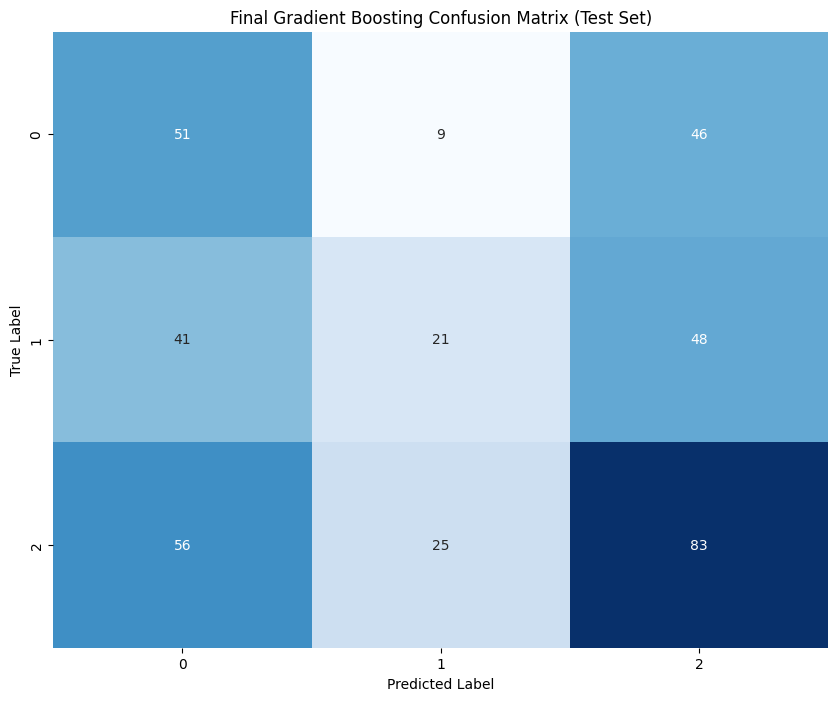

              precision    recall  f1-score   support

           A       0.34      0.48      0.40       106
           D       0.38      0.19      0.25       110
           H       0.47      0.51      0.49       164

    accuracy                           0.41       380
   macro avg       0.40      0.39      0.38       380
weighted avg       0.41      0.41      0.40       380



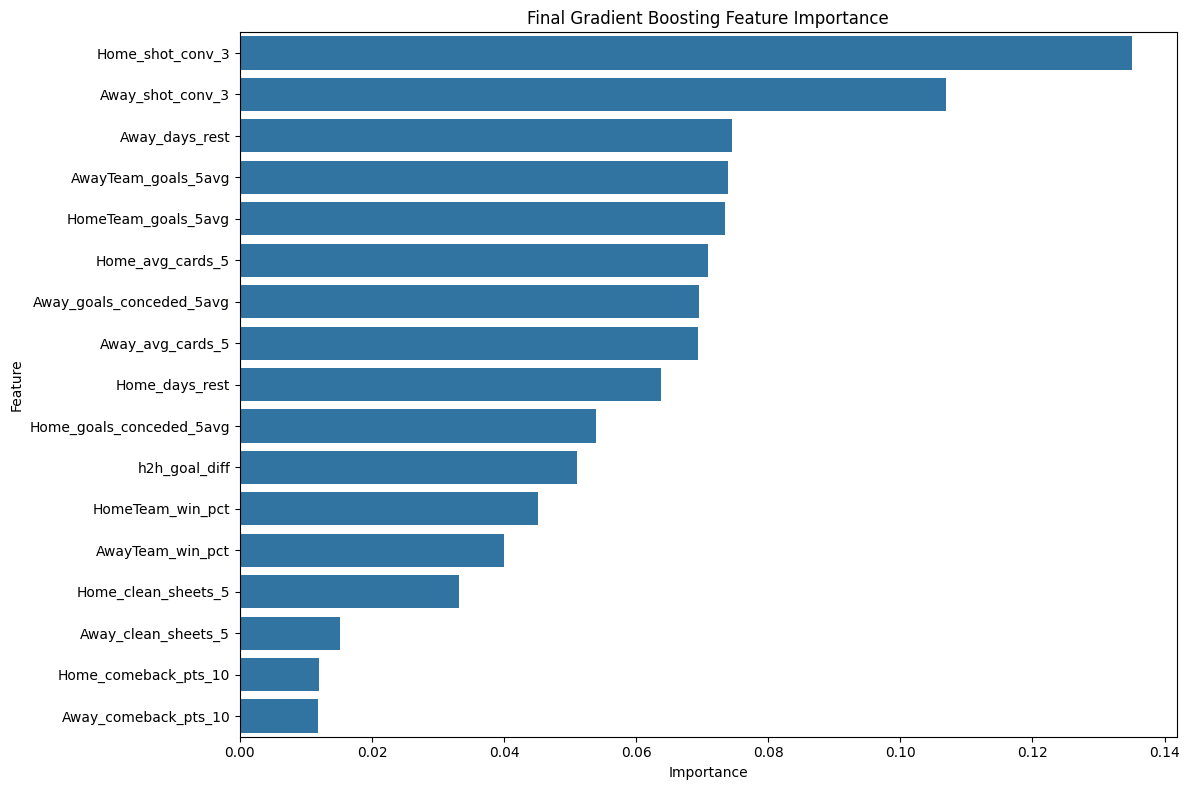

In [16]:
# Evaluate the best model on the test set
final_results = evaluate_model(best_model, X_train, y_train, X_val, y_val, X_test, y_test)
print("Final Model Results:")
for metric, value in final_results.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix for the test set
plot_confusion_matrix(best_model, X_test, y_test, title=f'Final {best_model_name} Confusion Matrix (Test Set)')

# If the best model is tree-based, plot feature importance
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    final_feature_importance = plot_feature_importance(best_model, X_train.columns, 
                                                      title=f'Final {best_model_name} Feature Importance')

## Save the Best Model

In [17]:
# Save the best model to disk
model_filename = f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model saved as {model_filename}")

Best model saved as best_model_gradient_boosting.pkl


## Conclusion

In this notebook, we trained and evaluated several machine learning models for match prediction. We compared their performance, tuned the hyperparameters of the best model, and evaluated it on the test set. The final model can be used for making predictions on new data.